In [11]:
import torch
import numpy as np
import pandas as pd
from hmmlearn import hmm as hmm_lib
from sklearn.metrics import accuracy_score, f1_score

In [ ]:


# Define model (same as training)
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(3, 64, kernel_size=7, padding=3)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.pool1 = torch.nn.MaxPool1d(2)
        
        self.conv2 = torch.nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.pool2 = torch.nn.MaxPool1d(2)
        
        self.conv3 = torch.nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.pool3 = torch.nn.MaxPool1d(2)
        
        self.gap = torch.nn.AdaptiveAvgPool1d(1)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


# Load model with weights_only=False
print("Loading model...")
checkpoint = torch.load(
    '/Users/akashmurali/Documents/capstone/project/HAR/human-activity-recognition/cnn/best_model.pth',
    map_location='cpu',
    weights_only=False
)

model = SimpleCNN(num_classes=10, dropout=0.5)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

label_encoder = checkpoint['label_encoder']
idx_to_label = {idx: label for label, idx in label_encoder.items()}

print(f"Model loaded")
print(f"Classes: {list(label_encoder.keys())}")
print(f"Val accuracy: {checkpoint.get('val_acc', 'N/A'):.2f}%")

# Load participant data
print("\nLoading data...")
X_all = np.load('/Users/akashmurali/Documents/capstone/project/capture24/preprocessed/X.npy')
Y_all = np.load('/Users/akashmurali/Documents/capstone/project/capture24/preprocessed/Y_WillettsSpecific2018.npy', allow_pickle=True)
P_all = np.load('/Users/akashmurali/Documents/capstone/project/capture24/preprocessed/P.npy', allow_pickle=True)

# Get one participant
participant_mask = P_all == 'P120'
X_test = X_all[participant_mask]
Y_test = Y_all[participant_mask]

print(f"\nParticipant P147:")
print(f"  Windows: {len(X_test)}")
print(f"  Duration: {len(X_test) * 10 / 3600:.2f} hours")

# Predict
print("\nMaking predictions...")
predictions = []
with torch.no_grad():
    for window in X_test:
        window_tensor = torch.FloatTensor(window).unsqueeze(0)
        output = model(window_tensor)
        pred = output.argmax(dim=1).item()
        predictions.append(idx_to_label[pred])

# Calculate accuracy
accuracy = (np.array(predictions) == Y_test).mean() * 100
print(f"\n Accuracy: {accuracy:.2f}%")

# Show some predictions
print("\nSample Predictions:")
print("-" * 50)
for i in range(0, len(predictions), 150):
    match = "✓" if predictions[i] == Y_test[i] else "✗"
    print(f"{match} Window {i}: Predicted={predictions[i]:20s} True={Y_test[i]}")

Loading model...
Model loaded
Classes: [np.str_('bicycling'), np.str_('household-chores'), np.str_('manual-work'), np.str_('mixed-activity'), np.str_('sitting'), np.str_('sleep'), np.str_('sports'), np.str_('standing'), np.str_('vehicle'), np.str_('walking')]
Val accuracy: 75.44%

Loading data...

Participant P147:
  Windows: 5114
  Duration: 14.21 hours

Making predictions...

 Accuracy: 67.23%

Sample Predictions:
--------------------------------------------------
✓ Window 0: Predicted=sleep                True=sleep
✓ Window 150: Predicted=sleep                True=sleep
✓ Window 300: Predicted=sleep                True=sleep
✓ Window 450: Predicted=sleep                True=sleep
✓ Window 600: Predicted=vehicle              True=vehicle
✗ Window 750: Predicted=household-chores     True=sitting
✓ Window 900: Predicted=sitting              True=sitting
✗ Window 1050: Predicted=sleep                True=sitting
✗ Window 1200: Predicted=walking              True=sitting
✓ Window 1350: 

#### LEARN TRANSITION MATRIX FROM TRAINING SET (P001-P100)

In [15]:
print("\n" + "="*70)
print("LEARNING TRANSITIONS FROM ALL TRAINING DATA")
print("="*70)

# Use ALL training data (no sampling)
train_pids = [f'P{i:03d}' for i in range(1, 101)]
train_mask = np.isin(P_all, train_pids)
valid_train_mask = train_mask & (Y_all != 'nan') & (~pd.isna(Y_all))

X_train = X_all[valid_train_mask]
Y_train = Y_all[valid_train_mask]

print(f"Full training set: {len(X_train):,} windows")

# Get predictions on ALL training data
print("Getting predictions (this may take a few minutes)...")
train_pred_idx = []

batch_size = 1000  # Process in batches for speed
for i in range(0, len(X_train), batch_size):
    batch_end = min(i + batch_size, len(X_train))
    batch = X_train[i:batch_end]
    
    with torch.no_grad():
        for window in batch:
            window_tensor = torch.FloatTensor(window).unsqueeze(0)
            output = model(window_tensor)
            pred_idx = output.argmax(dim=1).item()
            train_pred_idx.append(pred_idx)
    
    if (i // batch_size) % 10 == 0:
        print(f"  Processed {len(train_pred_idx):,} / {len(X_train):,} windows...")

train_pred_idx = np.array(train_pred_idx)
print(f"✓ Got {len(train_pred_idx):,} predictions")
n_classes = 10
# Learn transitions
print("\nLearning transitions...")
transitions = np.zeros((n_classes, n_classes))

for i in range(len(train_pred_idx) - 1):
    transitions[train_pred_idx[i], train_pred_idx[i+1]] += 1

print(f"Total transitions counted: {transitions.sum():.0f}")

# Normalize
transitions += 1.0
transitions = transitions / transitions.sum(axis=1, keepdims=True)

print(f"\n✓ Self-transition probabilities:")
for i in range(n_classes):
    print(f"  {idx_to_label[i]:20s}: {transitions[i, i]*100:.1f}%")


LEARNING TRANSITIONS FROM ALL TRAINING DATA
Full training set: 626,314 windows
Getting predictions (this may take a few minutes)...
  Processed 1,000 / 626,314 windows...
  Processed 11,000 / 626,314 windows...
  Processed 21,000 / 626,314 windows...
  Processed 31,000 / 626,314 windows...
  Processed 41,000 / 626,314 windows...
  Processed 51,000 / 626,314 windows...
  Processed 61,000 / 626,314 windows...
  Processed 71,000 / 626,314 windows...
  Processed 81,000 / 626,314 windows...
  Processed 91,000 / 626,314 windows...
  Processed 101,000 / 626,314 windows...
  Processed 111,000 / 626,314 windows...
  Processed 121,000 / 626,314 windows...
  Processed 131,000 / 626,314 windows...
  Processed 141,000 / 626,314 windows...
  Processed 151,000 / 626,314 windows...
  Processed 161,000 / 626,314 windows...
  Processed 171,000 / 626,314 windows...
  Processed 181,000 / 626,314 windows...
  Processed 191,000 / 626,314 windows...
  Processed 201,000 / 626,314 windows...
  Processed 211,0

### now using the transistion matrix test on participant P120

In [16]:
print("\n" + "="*70)
print("TESTING ON PARTICIPANT P120")
print("="*70)

# Get P120 data
participant_mask = P_all == 'P120'
valid_mask = participant_mask & (Y_all != 'nan') & (~pd.isna(Y_all))

X_test = X_all[valid_mask]
Y_test = Y_all[valid_mask]

print(f"Participant P120:")
print(f"  Windows: {len(X_test)}")
print(f"  Duration: {len(X_test) * 10 / 3600:.2f} hours")

# Get base predictions
print("\nGetting base predictions...")
base_pred_idx = []
true_idx = []

with torch.no_grad():
    for i, window in enumerate(X_test):
        window_tensor = torch.FloatTensor(window).unsqueeze(0)
        output = model(window_tensor)
        pred_idx = output.argmax(dim=1).item()
        base_pred_idx.append(pred_idx)
        true_idx.append(label_encoder[Y_test[i]])

base_pred_idx = np.array(base_pred_idx)
true_idx = np.array(true_idx)

base_accuracy = accuracy_score(true_idx, base_pred_idx)
print(f"✓ Base accuracy: {base_accuracy*100:.2f}%")


TESTING ON PARTICIPANT P120
Participant P120:
  Windows: 5114
  Duration: 14.21 hours

Getting base predictions...
✓ Base accuracy: 67.23%


In [21]:
from hmmlearn import hmm as hmm_lib

def apply_hmm_smoothing_fixed(base_predictions, transition_matrix, n_classes):
    """
    Working HMM implementation
    """
    # Method 1: Use GaussianHMM with discrete observations
    hmm_model = hmm_lib.GaussianHMM(
        n_components=n_classes,
        covariance_type='diag',
        n_iter=100
    )
    
    # Set parameters
    hmm_model.transmat_ = transition_matrix
    hmm_model.startprob_ = np.ones(n_classes) / n_classes
    
    # Emission: Each state emits its own index with high probability
    hmm_model.means_ = np.arange(n_classes).reshape(-1, 1)
    hmm_model.covars_ = np.ones((n_classes, 1)) * 0.5
    
    # Apply Viterbi
    obs = base_predictions.reshape(-1, 1).astype(float)
    smoothed = hmm_model.predict(obs)
    
    return smoothed


# Apply HMM
print("\nApplying HMM smoothing (fixed implementation)...")
smoothed_pred_idx = apply_hmm_smoothing_fixed(base_pred_idx, transitions, n_classes)

hmm_accuracy = accuracy_score(true_idx, smoothed_pred_idx)
print(f"✓ HMM accuracy: {hmm_accuracy*100:.2f}%")
print(f"  Improvement: +{(hmm_accuracy - base_accuracy)*100:.2f}%")

# Analyze changes
changes = (base_pred_idx != smoothed_pred_idx).sum()
print(f"\nPredictions changed: {changes} ({changes/len(base_pred_idx)*100:.2f}%)")

# Analyze smoothed predictions
print("\nAnalyzing smoothed predictions:")
smoothed_runs = []
current = smoothed_pred_idx[0]
length = 1

for i in range(1, len(smoothed_pred_idx)):
    if smoothed_pred_idx[i] == current:
        length += 1
    else:
        smoothed_runs.append((current, length))
        current = smoothed_pred_idx[i]
        length = 1
smoothed_runs.append((current, length))

print(f"Segments after HMM: {len(smoothed_runs)}")
print(f"Average segment: {np.mean([r[1] for r in smoothed_runs]):.1f} windows ({np.mean([r[1] for r in smoothed_runs])*10/60:.1f} min)")

print(f"\nBefore HMM: 1364 segments, avg 3.7 windows")
print(f"After HMM:  {len(smoothed_runs)} segments, avg {np.mean([r[1] for r in smoothed_runs]):.1f} windows")

# Show corrections
if changes > 0:
    corrections = ((base_pred_idx != true_idx) & (smoothed_pred_idx == true_idx)).sum()
    new_errors = ((base_pred_idx == true_idx) & (smoothed_pred_idx != true_idx)).sum()
    
    print(f"\nErrors corrected: {corrections}")
    print(f"New errors: {new_errors}")
    print(f"Net gain: {corrections - new_errors}")
    
    print("\nExample corrections:")
    count = 0
    for i in range(len(base_pred_idx)):
        if base_pred_idx[i] != smoothed_pred_idx[i]:
            base_label = idx_to_label[base_pred_idx[i]]
            smooth_label = idx_to_label[smoothed_pred_idx[i]]
            true_label = Y_test[i]
            status = "✓" if smoothed_pred_idx[i] == true_idx[i] else "✗"
            
            # Show context (previous and next)
            if i > 0 and i < len(base_pred_idx) - 1:
                prev = idx_to_label[smoothed_pred_idx[i-1]]
                next_pred = idx_to_label[smoothed_pred_idx[i+1]]
                print(f"{status} Win {i}: [{prev}] → {base_label:12s} → HMM:{smooth_label:12s} → [{next_pred}] (True:{true_label})")
            else:
                print(f"{status} Win {i}: {base_label:12s} → {smooth_label:12s} (True:{true_label})")
            
            count += 1
            if count >= 10:
                break


Applying HMM smoothing (fixed implementation)...
✓ HMM accuracy: 72.72%
  Improvement: +5.49%

Predictions changed: 569 (11.13%)

Analyzing smoothed predictions:
Segments after HMM: 633
Average segment: 8.1 windows (1.3 min)

Before HMM: 1364 segments, avg 3.7 windows
After HMM:  633 segments, avg 8.1 windows

Errors corrected: 397
New errors: 116
Net gain: 281

Example corrections:
✓ Win 1: [sleep] → sitting      → HMM:sleep        → [sleep] (True:sleep)
✓ Win 10: [sleep] → sitting      → HMM:sleep        → [sleep] (True:sleep)
✓ Win 55: [sleep] → sitting      → HMM:sleep        → [sleep] (True:sleep)
✓ Win 60: [sleep] → sitting      → HMM:sleep        → [sleep] (True:sleep)
✓ Win 175: [sleep] → sitting      → HMM:sleep        → [sleep] (True:sleep)
✓ Win 260: [sleep] → sitting      → HMM:sleep        → [sleep] (True:sleep)
✗ Win 278: [sleep] → sleep        → HMM:sitting      → [household-chores] (True:sleep)
✗ Win 280: [household-chores] → sleep        → HMM:sitting      → [sleep] (

In [23]:
class_names = [idx_to_label[i] for i in range(n_classes)]

In [24]:
print(class_names)

[np.str_('bicycling'), np.str_('household-chores'), np.str_('manual-work'), np.str_('mixed-activity'), np.str_('sitting'), np.str_('sleep'), np.str_('sports'), np.str_('standing'), np.str_('vehicle'), np.str_('walking')]


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


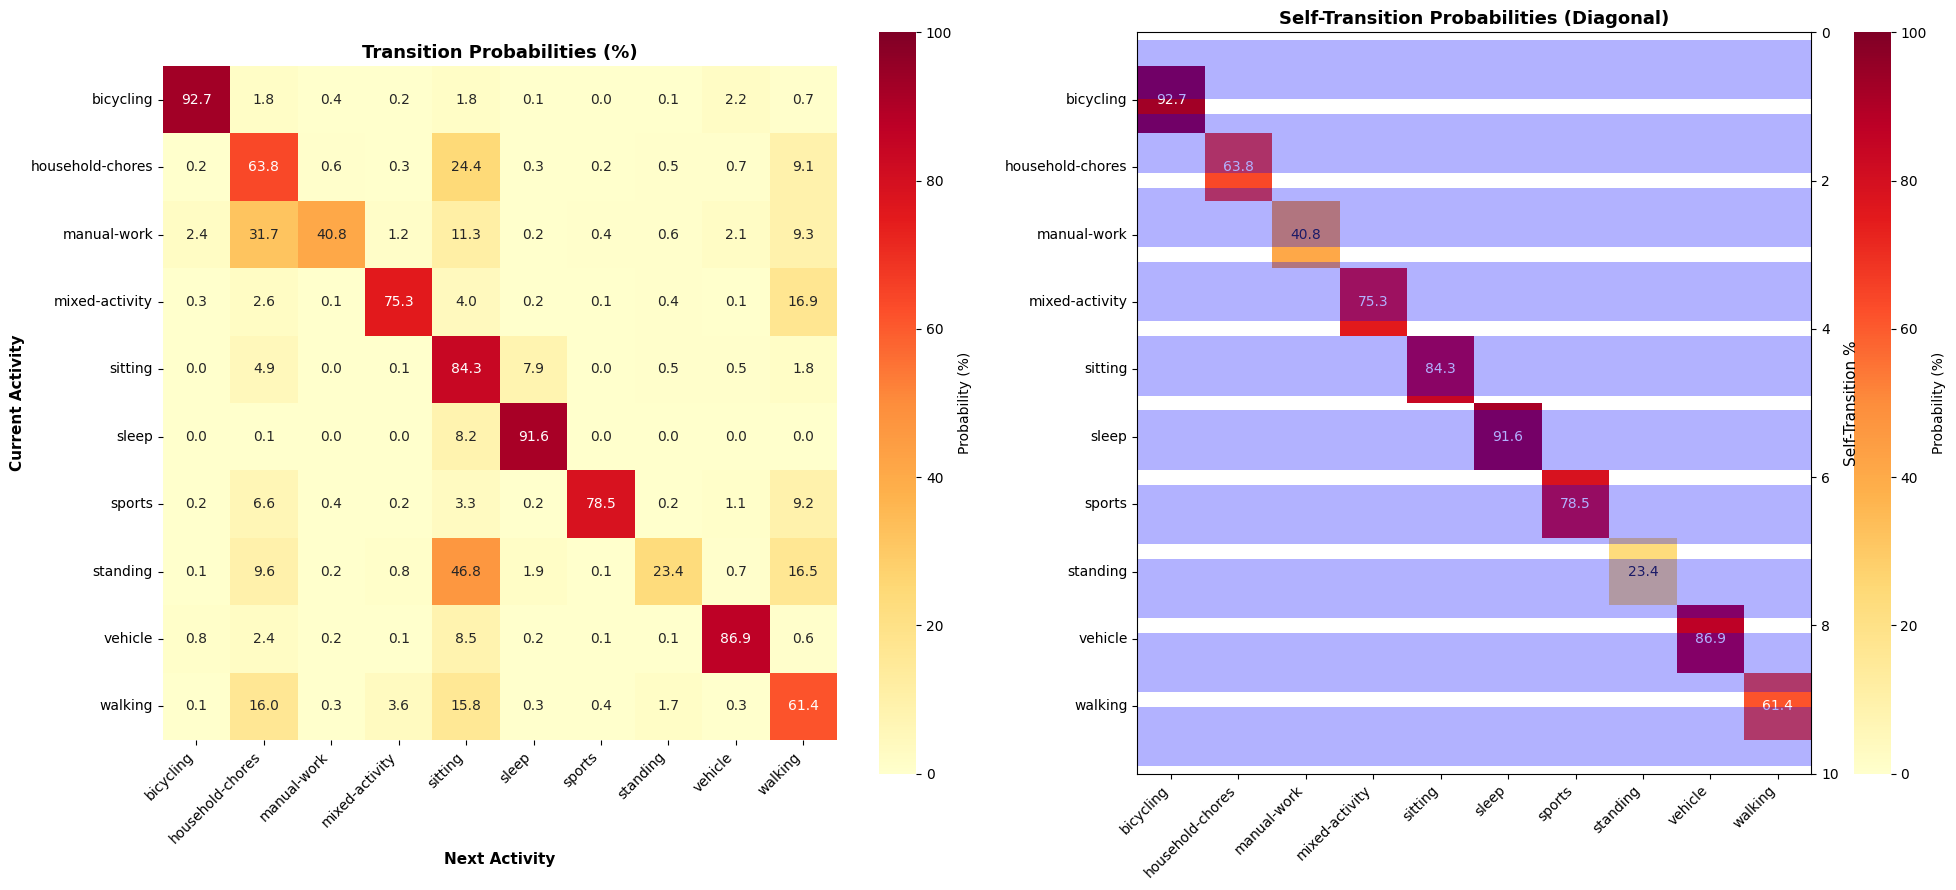

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_transition_detailed(transition_matrix, class_names):
    """
    Enhanced heatmap with additional insights
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    # Left: Full heatmap
    ax1 = axes[0]
    trans_percent = transition_matrix * 100
    
    sns.heatmap(
        trans_percent,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Probability (%)'},
        ax=ax1,
        vmin=0,
        vmax=100,
        square=True
    )
    
    ax1.set_xlabel('Next Activity', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Current Activity', fontsize=11, fontweight='bold')
    ax1.set_title('Transition Probabilities (%)', fontsize=13, fontweight='bold')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Right: Diagonal (self-transitions) highlighted
    ax2 = axes[1]
    
    # Create masked array to highlight diagonal
    masked_trans = trans_percent.copy()
    mask = np.zeros_like(masked_trans, dtype=bool)
    np.fill_diagonal(mask, True)
    
    sns.heatmap(
        masked_trans,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Probability (%)'},
        ax=ax2,
        mask=~mask,  # Only show diagonal
        vmin=0,
        vmax=100,
        square=True
    )
    
    # Add bar chart of self-transitions
    ax2_twin = ax2.twinx()
    diagonal = np.diag(trans_percent)
    y_pos = np.arange(len(diagonal)) + 0.5
    ax2_twin.barh(y_pos, diagonal, alpha=0.3, color='blue')
    ax2_twin.set_ylim(ax2.get_ylim())
    ax2_twin.set_ylabel('Self-Transition %', fontsize=11)
    
    ax2.set_title('Self-Transition Probabilities (Diagonal)', 
                  fontsize=13, fontweight='bold')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('transition_matrix_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()


# Plot detailed version
plot_transition_detailed(transitions, class_names)

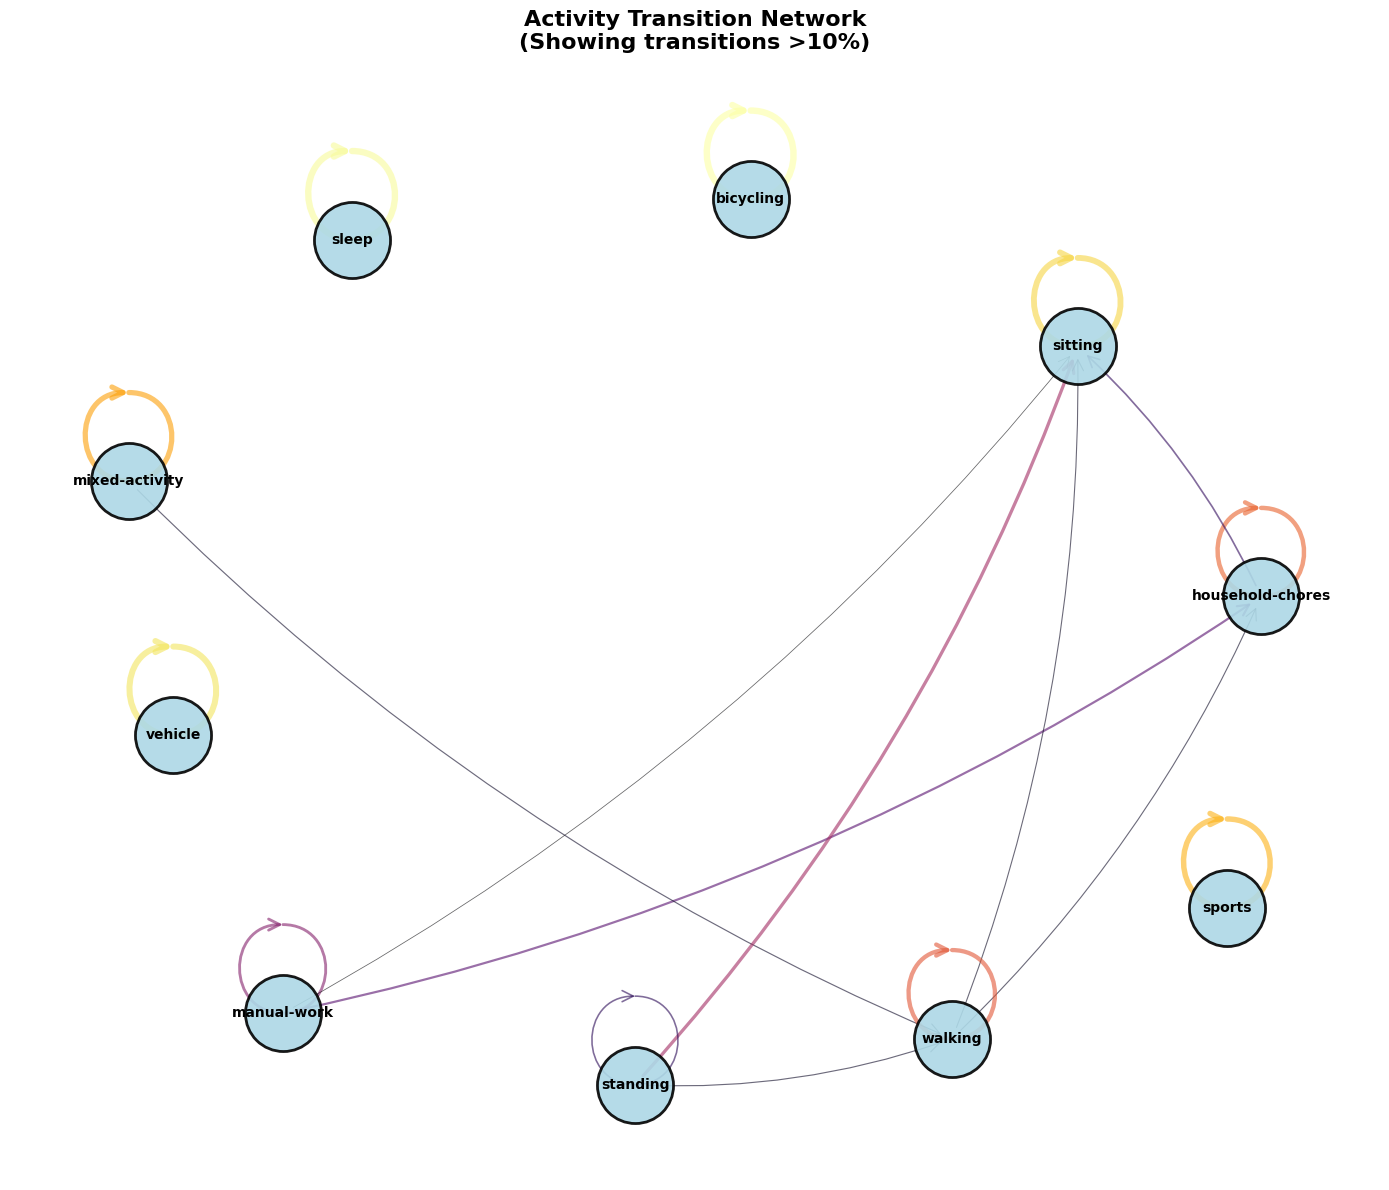

In [29]:
import networkx as nx

def plot_transition_network(transition_matrix, class_names, min_prob=0.1):
    """
    Visualize transitions as a directed graph
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for name in class_names:
        G.add_node(name)
    
    # Add edges for significant transitions
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if transition_matrix[i, j] > min_prob:
                G.add_edge(
                    class_names[i],
                    class_names[j],
                    weight=transition_matrix[i, j]
                )
    
    # Plot
    plt.figure(figsize=(14, 12))
    
    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', 
                          alpha=0.9, edgecolors='black', linewidths=2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw edges with varying thickness
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges,
        width=[w * 5 for w in weights],  # Thickness proportional to probability
        alpha=0.6,
        edge_color=weights,
        edge_cmap=plt.cm.inferno,
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1'
    )
    
    plt.title(f'Activity Transition Network\n(Showing transitions >{min_prob*100:.0f}%)', 
              fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('transition_network.png', dpi=300, bbox_inches='tight')
    plt.show()


# Plot network
plot_transition_network(transitions, class_names, min_prob=0.1)